# "Collaboration and Competition" project report

This is the report for the "Collaboration and Competition" project (P3) in Deep Reinforcement Learning Nanodegree.

## Environment

For this project, you will work with the Tennis environment.
In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1. If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01. Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping.

In [4]:
# load Tennis
env = UnityEnvironment(file_name="Tennis.app")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
print('The state for the second agent looks like:', states[1])

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]
The state for the second agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.4669857  -1.5
  0.          0.         -6.83172083  6.          0.          0.        ]


For later deep reinforcement learning, 

- No. agents: 2
- State space: 24
- Action size: 2
- Action type: continuous

are particularly important.

## Learning algorithm

## Model

In [7]:

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))

class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=128, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
            fc3_units (int): Number of nodes in the third hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

The model architecture I used for this project is the same one from the project 2.  
The Actor class defines actor network which is trained to output actions depending on states.  
The Actor has three layers with fc1_units=128, fc2_units=128 and fc3_units are number of actions.  
Meanwhile, Critic netwok defined by the Critic class learns to evaluate the actions given by the actor network.  
The Critic also has three layers with fcs1_units=128, fc2_units=128 and fc3_unit is one.  

## Agent

The Actor and Critic networks defined above will be trained with the Agent class which works as a helper class interacting with the environment.  

In [8]:

import numpy as np
import random
import copy
from collections import namedtuple, deque

from model import Actor, Critic

import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(3e4)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-3       # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agents():
    def __init__(self, state_size, action_size, random_seed, num_agents, train_mode, agent):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        self.num_agents = num_agents
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
        self.agent = agent
        self.agents = [self.agent(state_size, action_size, random_seed, num_agents, self.memory, idx, train_mode) for idx in range(self.num_agents)]
        self.train_mode = train_mode

    def step(self, states, actions, rewards, next_states, dones, timestep):
        if self.train_mode:
            rewards = np.reshape(rewards, self.num_agents, -1)
            dones = np.reshape(dones, self.num_agents, -1)
            self.memory.add(states, actions, rewards, next_states, dones)
            if len(self.memory) > BATCH_SIZE and timestep % 1 == 0:
                for _ in range(1):
                    experiences = self.memory.sample()
                    for idx, agent in enumerate(self.agents):
                        agent.learn(experiences, GAMMA, idx)

    def act(self, states, noise_weight=1.0, add_noise=True):
        actions = []
        for idx, agent in enumerate(self.agents):
            if self.agent == SharedMemoryAgent:
                action = agent.act(states[idx], noise_weight, add_noise)
            elif self.agent == SharedStateAgent:
                states = np.reshape(states, -1)
                action = agent.act(states, noise_weight, add_noise)
            actions.append(action)
        return np.array(actions)

    def reset(self):
        for agent in self.agents:
            agent.noise.reset()
    
    def soft_update(self, local_model, target_model, tau):
        for agent in self.agents:
            agent.soft_update(local_model, target_model, tau)
    
    def hard_update(self, target, source):
        for agent in self.agents:
            agent.hard_update(target, source)
    
    def noise_reset(self):
        for agent in self.agents:
            agent.noise.reset()

class SharedMemoryAgent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed, num_agents, Memory, id, train_mode):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        self.num_agents = num_agents
        self.id = id
        self.train_mode = train_mode

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
        
        # Noise process
        self.noise = OUNoise(action_size, random_seed)
        # Replay memory
        self.memory = Memory
    
        self.hard_update(self.actor_target, self.actor_local)
        self.hard_update(self.critic_target, self.critic_local)

    def act(self, states, noise_weight=1.0, add_noise=True):
        """Returns actions for given state as per current policy."""
        states = torch.from_numpy(states).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(states).cpu().data.numpy()
        self.actor_local.train()
        add_noise = self.train_mode
        if add_noise:
            self.noise_val = self.noise.sample() * noise_weight
            action += self.noise_val
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma, i):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
            t: time step
        """
        states, actions, rewards, next_states, dones = experiences
        
        agent_id = torch.tensor([i]).to(device)
        states = states.reshape(-1, 2, self.state_size).index_select(1, agent_id).squeeze(1)
        actions = actions.reshape(-1, 2, self.action_size).index_select(1, agent_id).squeeze(1)
        rewards = rewards.reshape(-1, 2, 1).index_select(1, agent_id).squeeze(1)
        dones = dones.reshape(-1, 2, 1).index_select(1, agent_id).squeeze(1)
        next_states = next_states.reshape(-1, 2, self.state_size).index_select(1, agent_id).squeeze(1)
        # print(states.shape, actions.shape, rewards.shape, dones.shape, next_states.shape)
        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)   

        # ----------------------- update noise ----------------------- #        
        self.noise.reset()


    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    def hard_update(self, target, source):
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(param.data)

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)


class SharedStateAgent(SharedMemoryAgent):
    def __init__(self, state_size, action_size, random_seed, num_agents, Memory, id, train_mode):
        super().__init__(state_size, action_size, random_seed, num_agents, Memory, id, train_mode)
        self.actor_local = Actor(state_size * self.num_agents, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size * self.num_agents, action_size, random_seed).to(device)
        self.critic_local = Critic(state_size * self.num_agents, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size * self.num_agents, action_size, random_seed).to(device)

    def learn(self, experiences, gamma, i,):
        states, actions, rewards, next_states, dones = experiences
        
        agent_id = torch.tensor([i]).to(device)
        states = states.reshape(-1, 1, self.state_size * self.num_agents).squeeze(1)
        actions = actions.reshape(-1, 2, self.action_size).index_select(1, agent_id).squeeze(1)
        rewards = rewards.reshape(-1, 2, 1).index_select(1, agent_id).squeeze(1)
        dones = dones.reshape(-1, 2, 1).index_select(1, agent_id).squeeze(1)
        next_states = next_states.reshape(-1, 1, self.state_size * self.num_agents).squeeze(1)

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)   

        # ----------------------- update noise ----------------------- #        
        self.noise.reset()
    

The agent architecture is based on the one from the project 2 but made some major changes to introduce a concept of MADDPG.  

so each agent still has the same methods from project 2, namely;
- act: Output the actions based on the states (you can choose to add noise defined in OUNoise class)
- step: Gather episode variables like state, action, next_step and add to memory buffer (see ReplayBuffer). If enough episodes are stored in the memory, update the network (learn)
- learn: update using TD estimate for Critic and Monte Carlo for Actor networks
- soft_update: soft update model parameters using θ_target = τ*θ_local + (1 - τ)*θ_target


And new major changes include;

- There is now Agents class that control multiple agents
- One episode is quite short in this project so I disabled epsilon/decay of noise that I introduced in project 2
- I wanted to introduce different levels of shared activities among agents. The most simple one, SharedMemoryAgent, is designed to share the same experiences with other agents
- SharedMemoryAgent is initiated with 2 action size and 24 state size
- In the meanwhile for SharedStateAgent, which is a child class of SharedMemoryAgent I like to loosen state observability condition a little bit and each actor and critic can observe states in the all agents (for now it doesn't really start learning well)


The parameters are as follows

- BUFFER_SIZE: int(3e4)  # replay buffer size
- BATCH_SIZE: 128        # minibatch size
- GAMMA: 0.99            # discount factor
- TAU: 1e-3              # for soft update of target parameters
- LR_ACTOR: 1e-3         # learning rate of the actor 
- LR_CRITIC: 1e-3        # learning rate of the critic
- WEIGHT_DECAY: 0        # L2 weight decay

## Model training

Actual interaction with environment is done by the below helper function that has multiple for loops in it and updates networks.

In [9]:
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from agents import *

agent_names = {
    'SharedMemoryAgent': SharedMemoryAgent,
    'SharedStateAgent': SharedStateAgent
}

In [10]:
def runner(n_episodes=4000, max_t=20000, print_every=100, train_mode=True, agent_name = 'SharedMemoryAgent'):
    env_info = env.reset(train_mode=train_mode)[brain_name]
    scores_deque = deque(maxlen=100)
    scores = np.zeros(num_agents)
    agent = Agents(
        state_size=state_size, action_size=action_size, random_seed=2,
        num_agents=num_agents, train_mode=train_mode, agent=agent_names[agent_name])
    if train_mode == False:
        for idx, a in enumerate(agent.agents):
            a.actor_local.load_state_dict(torch.load('checkpoint_actor_{agent_str}_{idx}.pth'.format(agent_str=agent_name, idx=idx)))
            a.critic_local.load_state_dict(torch.load('checkpoint_critic_{agent_str}_{idx}.pth'.format(agent_str=agent_name, idx=idx)))
    scores_global = []
    i_episode = 0
    while True:
        env_info = env.reset(train_mode=train_mode)[brain_name]
        states = env_info.vector_observations 
        agent.reset()
        trewards = [[0] for _ in range(num_agents)]
        agent.noise_reset()
        for t in range(max_t):
            if train_mode:
                if i_episode < 100:
                    actions = np.random.randn(num_agents, action_size)
                    actions = np.clip(actions, -1, 1)  
                else:
                    actions = agent.act(states)
            else:
                actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            agent.step(states, actions, rewards, next_states, dones, t)
            states = next_states 
            for i in range(agent.num_agents):
                if rewards[i] != 0:
                    trewards[i].append(rewards[i])
            if (np.any(dones)):
                break
        i_episode += 1
        per_agent_rewards = [sum(trewards[i]) for i in range(agent.num_agents)]
        score = np.max(per_agent_rewards)
        scores_global.append(score)
        scores_deque.append(score)
        avg_score = np.mean(scores_deque)
        
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(
            i_episode, avg_score, score), end="")
        if train_mode:
            for idx, a in enumerate(agent.agents):
                torch.save(a.actor_local.state_dict(), 'checkpoint_actor_{agent_str}_{idx}.pth'.format(agent_str=agent_name, idx=idx))
                torch.save(a.critic_local.state_dict(), 'checkpoint_critic_{agent_str}_{idx}.pth'.format(agent_str=agent_name, idx=idx))
            if avg_score > 0.5:
                print("\rsolved")
                for idx, a in enumerate(agent.agents):
                    torch.save(a.actor_local.state_dict(), 'checkpoint_actor_{agent_str}_{idx}.pth'.format(agent_str=agent_name, idx=idx))
                    torch.save(a.critic_local.state_dict(), 'checkpoint_critic_{agent_str}_{idx}.pth'.format(agent_str=agent_name, idx=idx))
                return scores_global
        
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(
            i_episode, avg_score, score))
            
    return scores_global

This runner function allows to do a basic reinforcement learning iteration as follows.  

- The agent, state and score are initialized
- for each episode
- get state, action, reward, next_state
- call step function (add the episode variables to memory and perform learning if enough data is stored in memory)
- iterate this process and observe the score

I realized positive actions are so sparse in this environment.  
Just in order to get an initial learning on track at early stage, the agents take random actions till they experience 100 episodes. Random actions tend to lead to more positive results than actions given by early stage networks.  

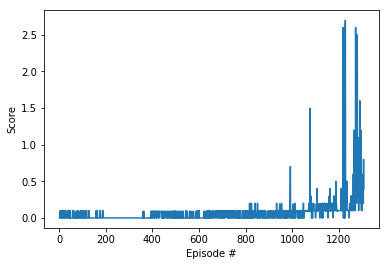

In this case the score reached 0.5 at 1307th episode.

## Ideas for future work

MARL is an actively researched area so there are plenty of things I like to try
- Introduce different levels of "sharedness" among agents like SharedStateAgent. In Tennis it would be natural to assume that the both agents can observe everything
- Try to compare agents not only reacheability to 0.5 but highest scores or learning speed
